Implementing a toy simulation for Bayesian A/B test with Gaussian distributed success metric.  

Context:  
- user-level randomization
- two groups
- imbalanced weights
- same user can have repeated measurements
- multiple aggregation levels
  - many reads a day
  - daily aggregation
  - cumulative aggregation over period

Examples of practical business metrics that match the case:
- revenue / user
- transactions / user (approx. as we know transactions follow a discrete distribution)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ideal case

Just a toy example with ideally Gaussian distributed before we go into a more structured dataset.

In [2]:
# two-part posterior model
# P(Revenue per User)=P(Conversion)×P(Transaction Value | Conversion)

# y i in {0,1} represent whether user i converted (y i=1) or not (y i =0).
# t i represent the transaction value (revenue) for user i, but it is only observed when y i =1.

# p is the probability of conversion, and it follows a prior p∼Beta(α p ,β p ).
# T is the transaction value for converters, assumed to follow a continuous distribution, say 
# T∼Gamma(α T ,β T ), where α T and β T are the shape and rate parameters, respectively, with their own priors.

num_users = 10000

true_prob_user_converting = 0.1
# priors are set to be non-informative thus alpha_0 + beta_0 = 2
alpha_p = true_prob_user_converting * (num_users + 2)
beta_p = (1 - true_prob_user_converting) * (num_users + 2)

# we'll write priors as function of average ticket value (atv) and spread (std) of revenue/transaction
atv = 10
std = 20 # large spread due to long tail of revenue distribution

coeff_of_var = std / atv
dispersion_index = (std ** 2) / atv

true_alpha_T = 1 / (coeff_of_var ** 2) 
true_beta_T = 1 / dispersion_index

print(f"Calculated Gamma parameters -> alpha_T: {true_alpha_T:.2f}, beta_T: {true_beta_T:.2f}")


Calculated Gamma parameters -> alpha_T: 0.25, beta_T: 0.03


Number of users: 10000
Number of converted users: 1039
Total revenue from converted users: $9969.74
Average revenue per user (RPU): $1.00
Average revenue per converted user: $9.60


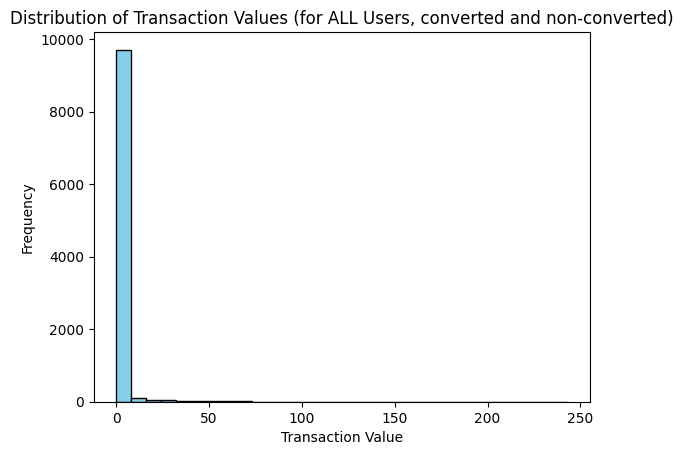

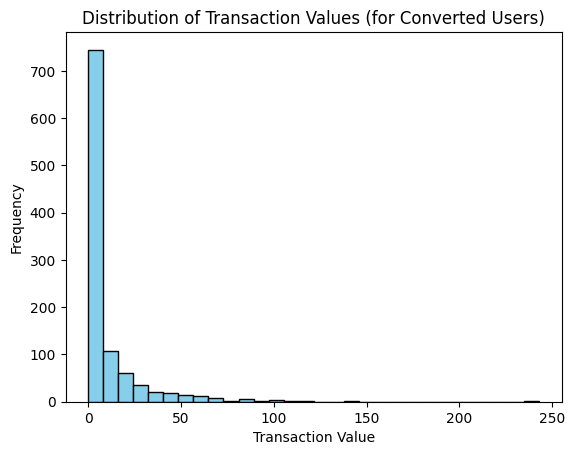

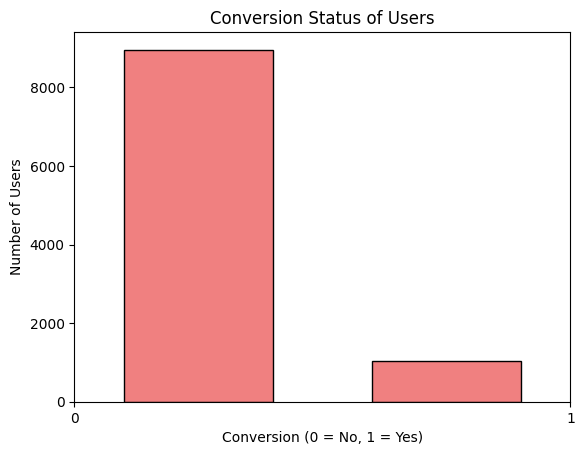

In [3]:
# Part 1: Simulate user conversions
# Simulate conversion probabilities from the Beta distribution
p = np.random.beta(alpha_p, beta_p, size=num_users)  # Converting probability for each user

# Simulate whether each user converted or not (Bernoulli trial)
conversions = np.random.binomial(1, true_prob_user_converting, size=num_users)

# Part 2: Simulate transaction values for users who converted
# Transaction values are drawn from a Gamma distribution only for converting users
transaction_values = np.zeros(num_users)  # Initialize with zeros
transaction_values[conversions == 1] = np.random.gamma(true_alpha_T, 1 / true_beta_T, size=sum(conversions))

# Summary statistics
num_converted_users = np.sum(conversions)
total_revenue = np.sum(transaction_values)

# Print summary
print(f"Number of users: {num_users}")
print(f"Number of converted users: {num_converted_users}")
print(f"Total revenue from converted users: ${total_revenue:.2f}")
print(f"Average revenue per user (RPU): ${total_revenue / num_users:.2f}")
print(f"Average revenue per converted user: ${total_revenue / num_converted_users:.2f}")

# Visualize the distribution of transaction values for all users
plt.hist(transaction_values, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Transaction Values (for ALL Users, converted and non-converted)")
plt.xlabel("Transaction Value")
plt.ylabel("Frequency")
plt.show()

# Visualize the distribution of transaction values for converting users
plt.hist(transaction_values[transaction_values > 0], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Transaction Values (for Converted Users)")
plt.xlabel("Transaction Value")
plt.ylabel("Frequency")
plt.show()

# Plot conversion histogram
plt.hist(conversions, bins=2, color='lightcoral', edgecolor='black', rwidth=0.6)
plt.title("Conversion Status of Users")
plt.xlabel("Conversion (0 = No, 1 = Yes)")
plt.ylabel("Number of Users")
plt.xticks([0, 1])
plt.show()

In [4]:
def conversion_params_given_true_p(true_p, num_samples=2):
    """Returns the alpha and beta parameters of a Beta distribution given the true conversion probability.  
    Num_samples proxies a precision of the beta distribution (alpha + beta).
    """
    alpha = true_p * num_samples
    beta = (1 - true_p) * num_samples
    return alpha, beta

def transaction_parameters_given_average_ticket_value(atv, std):
    """Returns the shape and rate parameters of a Gamma distribution given known values for average ticket value and its standard deviation (spread)."""
    coeff_of_var = std / atv
    dispersion_index = (std ** 2) / atv
    alpha = 1 / (coeff_of_var ** 2)
    beta = 1 / dispersion_index
    return alpha, beta

def users_probability_conversion(alpha_p, beta_p, num_users):
    """Samples the conversion probability for each user from a Beta distribution."""
    p = np.random.beta(alpha_p, beta_p, size=num_users)
    return p

def users_conversion_status(p):
    """Simulates the conversion status (0 or 1) for each user based on the conversion probability."""
    conversions = np.random.binomial(1, p, size=len(p))
    return conversions

def users_transaction_values(alpha_t, beta_t, num_users):
    """Assuming every user converted, samples transaction values from a Gamma distribution."""
    transaction_values = np.random.gamma(alpha_t, 1 / beta_t, size=num_users)
    return transaction_values

def simulate_user_data(true_prob_user_converting, atv, std, num_users):
    # Calculate the parameters of the Beta distribution for conversion probability
    alpha_p, beta_p = conversion_params_given_true_p(true_prob_user_converting, num_users)
    
    # Calculate the parameters of the Gamma distribution for transaction values
    alpha_t, beta_t = transaction_parameters_given_average_ticket_value(atv, std)
    
    # Simulate user conversions
    p = users_probability_conversion(alpha_p, beta_p, num_users)
    conversions = users_conversion_status(p)
    
    # Simulate transaction values for converting users
    transaction_values = users_transaction_values(alpha_t, beta_t, num_users)
    
    # nulls for non-converting users
    transaction_values[conversions == 0] = 0
    
    return conversions, transaction_values

In [5]:
# generate a/b test data
seed = 123456

# tuple of parameters for each group: (true_prob_user_converting, atv, std) 
params_per_group = {
    "A": (0.1, 10, 20),
    "B": (0.12, 10, 20)
}

num_total_users = 10000
weight_control = 0.5
weight_treatment = 1 - weight_control

num_users_control = int(num_total_users * weight_control)
num_users_treatment = num_total_users - num_users_control

# dataset control
conversions_control, transaction_values_control = simulate_user_data(*params_per_group["A"], num_users_control)
conversions_treatment, transaction_values_treatment = simulate_user_data(*params_per_group["B"], num_users_treatment)

# pandas DataFrame
df = pd.DataFrame({
    "Group": ["A"] * num_users_control + ["B"] * num_users_treatment,
    "Conversions": np.concatenate([conversions_control, conversions_treatment]),
    "TransactionValue": np.concatenate([transaction_values_control, transaction_values_treatment])
})
df

,Group,Conversions,TransactionValue
0,A,0,0.000000e+00
1,A,1,2.651608e-07
2,A,0,0.000000e+00
3,A,1,1.257769e+01
4,A,0,0.000000e+00
...,...,...,...
9995,B,0,0.000000e+00
9996,B,0,0.000000e+00
9997,B,0,0.000000e+00
9998,B,0,0.000000e+00


In [6]:
# point estimates of the likelihood of conversion and transaction per group
df.groupby("Group").mean()

,Conversions,TransactionValue
Group,,
A,0.1010,0.876870
B,0.1238,1.217813


In [7]:
df[df["Conversions"] > 0].groupby("Group").mean()

,Conversions,TransactionValue
Group,,
A,1.0,8.681880
B,1.0,9.836936


### priors of gamma parameters

Let's break it down for both 𝛼ₜ (shape) and 𝛽ₜ (rate), and we'll explore how to set the parameters 𝑎ₜ, 𝑏ₜ (for 𝛼ₜ) and 𝑐ₜ, 𝑑ₜ (for 𝛽ₜ).

#### 1. Setting Priors for 𝛼ₜ (Shape Parameter)
The shape parameter 𝛼ₜ in a Gamma distribution affects the skewness and the behavior of the distribution:

- If 𝛼ₜ > 1, the Gamma distribution is unimodal and more symmetrical.
- If 𝛼ₜ = 1, the Gamma distribution becomes an exponential distribution.
- If 𝛼ₜ < 1, the Gamma distribution is highly skewed.

The goal is to set a Gamma prior on 𝛼ₜ with parameters 𝑎ₜ and 𝑏ₜ.

##### Choice of 𝑎ₜ and 𝑏ₜ (Gamma Prior for 𝛼ₜ):
- **Non-informative Prior**: A Gamma(1, 1) prior on 𝛼ₜ would serve as a common non-informative prior, allowing 𝛼ₜ to vary freely while being positive. This prior reflects a weak belief that 𝛼ₜ is around 1 (exponential), but allows for a wide range of possible values.
- **Weakly Informative Prior**: If you want a more diffuse prior, you can choose Gamma(0.001, 0.001) to make it almost flat, which is commonly used when we want the prior to have little influence. This means that 𝛼ₜ can take any positive value, with very weak prior information.

#### 2. Setting Priors for 𝛽ₜ (Rate Parameter)
The rate parameter 𝛽ₜ (inverse of the scale) in the Gamma distribution determines how spread out the distribution is:

- Smaller values of 𝛽ₜ correspond to more spread (larger expected transaction values).
- Larger values of 𝛽ₜ correspond to tighter distributions around smaller values.

You want a Gamma prior on 𝛽ₜ with parameters 𝑐ₜ and 𝑑ₜ.

##### Choice of 𝑐ₜ and 𝑑ₜ (Gamma Prior for 𝛽ₜ):
- **Non-informative Prior**: A Gamma(1, 1) prior on 𝛽ₜ would act as a non-informative prior, implying that you have little information about the rate, but expect it to be around 1. This choice means that the prior is centered around 1, but allows for a wide range of possible rate values.
- **Weakly Informative Prior**: If you want the prior to be even less informative, Gamma(0.001, 0.001) can be used, meaning you have almost no prior information about 𝛽ₜ, allowing it to be highly uncertain.

#### Summary of Priors for 𝛼ₜ and 𝛽ₜ:
- **For 𝛼ₜ (shape of the Gamma distribution for transaction values):**
  - Non-informative prior: Gamma(1, 1)
  - Weakly informative prior: Gamma(0.001, 0.001)
  
- **For 𝛽ₜ (rate of the Gamma distribution for transaction values):**
  - Non-informative prior: Gamma(1, 1)
  - Weakly informative prior: Gamma(0.001, 0.001)


In [8]:
# priors constants

# priors for conversion probability
# assumption: p∼Beta(α0p, β0p​)
alpha_0_p = 1
beta_0_p = 1

# priors for transaction value
# assumption: T∼Gamma(αT, βT​)
# alpha_T ~ Gamma(a0T, b0T)
# beta_T ~ Gamma(c0T, d0T)

# alpha determines the shape of the distribution (expected to be < 1, meaning highly skewed distribution)
# weakly informative prior: more flat, go with low values of alpha, beta pair
a0_T = 0.001
b0_T = 0.001
 
 # beta determines how spread out the distribution is 
 # (smaller values of beta, more spread out meaning expect more high value transactions)
 # (larger values of beta, tigher distribution, expect more low value transactions around the average)
c0_T = 0.001
d0_T = 0.001



### posterior

$$
\log P(p, \alpha_T, \beta_T \mid D) \propto 
\sum_{i=1}^{N} \left[ (1 - y_i) \log(1 - p) + y_i \left( \log(p) + \alpha_T \log(\beta_T) - \log(\Gamma(\alpha_T)) + (\alpha_T - 1) \log(t_i) - \beta_T t_i \right) \right] \\
+ (\alpha_p - 1) \log(p) + (\beta_p - 1) \log(1 - p) \\
+ (\alpha_p - 1) \log(p) + (\beta_p - 1) \log(1 - p) \\
+ (a_T - 1) \log(\alpha_T) - b_T \alpha_T + (c_T - 1) \log(\beta_T) - d_T \beta_T.

$$

#### MAP estimator

In [9]:
import numpy as np
from scipy.special import gamma, gammaln
from scipy.optimize import minimize

# Define the negative log posterior function
def neg_log_posterior(params, y, t, alpha_p, beta_p, a_T, b_T, c_T, d_T):
    p, alpha_T, beta_T = params
    N = len(y)
    
    # Log-posterior computation
    log_prior_p = (alpha_p - 1) * np.log(p) + (beta_p - 1) * np.log(1 - p)
    log_prior_alpha_T = (a_T - 1) * np.log(alpha_T) - b_T * alpha_T
    log_prior_beta_T = (c_T - 1) * np.log(beta_T) - d_T * beta_T
    
    log_likelihood = 0
    for i in range(N):
        if y[i] == 0:
            log_likelihood += np.log(1 - p)
        else:
            log_likelihood += np.log(p) + alpha_T * np.log(beta_T) - gammaln(alpha_T) + (alpha_T - 1) * np.log(t[i]) - beta_T * t[i]
    
    log_posterior = log_likelihood + log_prior_p + log_prior_alpha_T + log_prior_beta_T
    return -log_posterior  # We minimize, so return negative of log posterior

# Initial guess for p, alpha_T, and beta_T
initial_guess = [0.5, 1.0, 1.0]

# Hyperparameters for priors
alpha_p = 2.0
beta_p = 2.0
a_T = 2.0
b_T = 1.0
c_T = 2.0
d_T = 1.0

# Data (y_i and t_i)
y = np.array([0, 1, 1, 0, 1])  # Example data
t = np.array([0.5, 1.0, 2.0, 1.5, 1.2])  # Example data

# Perform the optimization
result = minimize(neg_log_posterior, initial_guess, args=(y, t, alpha_p, beta_p, a_T, b_T, c_T, d_T), bounds=[(0.01, 0.99), (0.01, None), (0.01, None)])

# Extract the optimal values of p, alpha_T, and beta_T
p_opt, alpha_T_opt, beta_T_opt = result.x
print("Optimal p:", p_opt)
print("Optimal alpha_T:", alpha_T_opt)
print("Optimal beta_T:", beta_T_opt)


Optimal p: 0.571425982692745
Optimal alpha_T: 1.9987394589814773
Optimal beta_T: 1.345439230940503


In [10]:
yi = df[df["Group"] == "A"]["Conversions"]
ti = df[df["Group"] == "A"]["TransactionValue"]

# initial guess from data
initial_guess_p = yi.mean()
point_estimate_atv = ti[yi > 0].mean()
std_estimate_atv = ti[yi > 0].std()
initial_guess_alpha_T, initial_guess_beta_T = transaction_parameters_given_average_ticket_value(point_estimate_atv, std_estimate_atv)

initial_guess = [initial_guess_p, initial_guess_alpha_T, initial_guess_beta_T]
# Perform the optimization
result = minimize(
    neg_log_posterior, 
    initial_guess, 
    args=(
        yi, 
        ti, 
        alpha_0_p, 
        beta_0_p, 
        a0_T, 
        b0_T, 
        c0_T, 
        d0_T), 
    bounds=[
        (0.0001, 0.9999), 
        (0.001, None), 
        (0.001, None)]
)

# Extract the optimal values of p, alpha_T, and beta_T
p_opt, alpha_T_opt, beta_T_opt = result.x
print("Optimal p:", p_opt)
print("Optimal alpha_T:", alpha_T_opt)
print("Optimal beta_T:", beta_T_opt)
# mean ATV from estimated alpha_T and beta_T
mean_atv = alpha_T_opt / beta_T_opt
print(f"Mean ATV: {mean_atv:.2f}")

Optimal p: 0.10100009611241459
Optimal alpha_T: 0.268216138248175
Optimal beta_T: 0.030665901841804764
Mean ATV: 8.75


#### MCMC (Hamiltonian Monte Carlo)

In [12]:
import pymc as pm
import aesara
import aesara.tensor as at
import pytensor

# Disable the use of C++ compiler and force Python-only implementations
pytensor.config.cxx = ""
aesara.config.cxx = ""
aesara.config.blas__ldflags = ""

# Data
y = np.array([0, 1, 1, 0, 1])  # Example binary data
t = np.array([0.5, 1.0, 2.0, 1.5, 1.2])  # Example time data

with pm.Model() as model:
    # Priors for the parameters
    p = pm.Beta('p', alpha=2.0, beta=2.0)
    alpha_T = pm.Gamma('alpha_T', alpha=2.0, beta=1.0)
    beta_T = pm.Gamma('beta_T', alpha=2.0, beta=1.0)
    
    # Likelihood function using aesara's gammaln function
    likelihood = pm.Potential('likelihood', 
        at.sum(
            (1 - y) * at.log(1 - p) + 
            y * (at.log(p) + alpha_T * at.log(beta_T) - at.gammaln(alpha_T) + 
                 (alpha_T - 1) * at.log(t) - beta_T * t)
        )
    )
    
    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=False, progressbar=True)

# Summarize the posterior samples
pm.summary(trace)


ModuleNotFoundError: No module named 'distutils.msvccompiler'